In [1]:
using CSV, DataFrames, ReverseDiff, Flux, LinearAlgebra, Distributions, Plots
using Flux:update!

In [2]:
function NN(θ,x)
    W1, b1 = reshape(θ[1:7*16],(16,7)), θ[7*16+1:7*16+16]
    W2, b2 = θ[7*16+17:7*16+32], θ[end]
    return W2'*tanh.(W1*x+b1)+b2
end

NN (generic function with 1 method)

In [3]:
p_ξ = MvNormal(zeros(7*16+33), ones(7*16+33))
p_likelihood(x,ξ) = Normal(NN(ξ,x),1)
;

In [4]:
q_ξ(ϕ) = MvNormal(ϕ[1:Int(length(ϕ)/2)],ϕ[Int(length(ϕ)/2)+1:end].^2)
log_q(ξ,ϕ) = logpdf(q_ξ(ϕ),ξ)
;

In [5]:
csv_read = CSV.File("data/cascadedtanks/dataBenchmark.csv");

In [6]:
df = DataFrame(csv_read)
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]
;

In [7]:
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
y_train = (y_train.-m_y)./s_y
y_val = (y_val.-m_y)./s_y
u_train = (u_train.-m_u)./s_u
u_val = (u_val.-m_u)./s_u
;

In [8]:
# Training
FreeEnergy(N,y,x,ϕ,ϵ_s) = log_q(ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s,ϕ) - logpdf(p_ξ,ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s) - N*logpdf(p_likelihood(x,ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s),y)

ϕ = [zeros(7*16+33);0.1*ones(7*16+33)] # initialize ϕ
N = length(y_train)
for epoch=1:10
    FE = 0
    error = [0., 0.]
    for i=1:N
        if i==1
            x_i = [u_train[i];zeros(6)] # [u_t, u_{t-1}, u_{t-2}, y_{t-1}, y_{t-2}, e_{t-1}, e_{t-2}]
        elseif i == 2
            x_i = [u_train[i],u_train[i-1],0,y_train[i-1],0, error[1],error[2]]
        else
            x_i = [u_train[i],u_train[i-1],u_train[i-2],y_train[i-1],y_train[i-2], error[1],error[2]]
        end
        ϵ_s = randn(Int(length(ϕ)/2))
        FreeEnergy(ϕ) = FreeEnergy(N,y_train[i],x_i,ϕ,ϵ_s)
        FE += FreeEnergy(ϕ)
        ∇_ϕ = gradient(FreeEnergy,ϕ)[1]
        update!(ADAM(), ϕ, ∇_ϕ)
        error[2] = error[1]
        error[1] = y_train[i] - NN(ϕ[1:Int(length(ϕ)/2)] + ϕ[Int(length(ϕ)/2)+1:end].*ϵ_s,x_i)
    end
    println(FE)
end

-1.5824005921921724e30
-9.469006001658006e29
-2.4168913873917498e29
-1.7206155569948556e29
-1.7303068107149878e29
-1.902387461425083e29
-1.4557154051693345e29
-1.3589701753909997e29
-1.374424214980675e29
-1.447195467375459e29


In [9]:
println(ϕ)

[0.029000156174560143, -0.02400037394905674, -0.02900001460418907, 0.027999787306054687, -0.02600000687344647, 0.026000374659265867, -0.02399997721148586, 0.02499956070663387, 0.02600002215526167, -0.026000060495360952, -0.0269999082476928, 0.026999990394748978, 0.026999896120083577, 0.028999164180459114, -0.025000091706292485, -0.028003192527868984, 0.005999811094570736, -0.0030000719291504068, -0.003999888746800024, 0.004000051816985923, -0.003999809363846753, 0.0039999870073425675, -0.003999975096120647, 0.002999902337589873, 0.0029999722728627017, -0.003999554151254171, -0.0029999415440378633, 0.005999970254675799, 0.0059999179528603406, 0.005999817723763411, -0.0030000402135718146, -0.003999983623102388, -0.031000025695006084, 0.021999773972591296, 0.030000023158602996, -0.031999925508980946, 0.029999937289854364, -0.02699983098746221, 0.02800015396509491, -0.024000073211164555, -0.027999985780325143, 0.02799977983991812, 0.024999935062140027, -0.03399993969043814, -0.029000029854

In [10]:
# Prediction
q = q_ξ(ϕ)

predictions = []
for i=1:length(y_val)
    error = [0., 0.]
    if i==1
        x_i = [u_val[i];zeros(6)] # [u_t, u_{t-1}, u_{t-2}, y_{t-1}, y_{t-2}, e_{t-1}, e_{t-2}]
    elseif i == 2
        x_i = [u_val[i],u_val[i-1],0,y_val[i-1],0, error[1],error[2]]
    else
        x_i = [u_val[i],u_val[i-1],u_val[i-2],y_val[i-1],y_val[i-2], error[1],error[2]]
    end
    predict = zeros(100)
    for n=1:100
        θ_s = rand(q)
        predict[n] = NN(θ_s,x_i)
    end
    error[2] = error[1]
    error[1] = y_val[i] - mean(predict)
    push!(predictions,Normal(mean(predict),std(predict)))
end

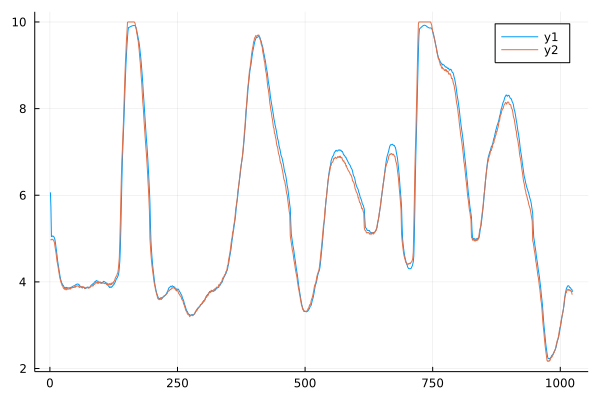

In [11]:
plot(mean.(m_y .+ s_y.*predictions),ribbon=var.(m_y .+ s_y.*predictions))
plot!(m_y .+ s_y.*y_val)

In [12]:
RMSE = sqrt(var(mean.(m_y .+ s_y.*predictions) .- (m_y .+ s_y.*y_val)))

0.16330922497961906